In [147]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline


import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

## Import Data

In [3]:
wr_stats = pd.read_csv('./data/agg_wr_final.csv')
def_points_allowed = pd.read_csv('./data/def_fpoints.csv').rename({'defteam':'team'}, axis=1)
def_injuries = pd.read_csv('./data/inj_defense.csv')
qb_stats = pd.read_csv('./data/qb_stats.csv')

In [4]:
wr_stats = wr_stats[wr_stats['position']=='WR']

In [5]:
wr_stats[['player_id', 'player_name', 'game_id', 'week', 'receiving_fpoints', 'espn_projection']].head()

player_id      player_name          game_id  week  receiving_fpoints  \
2   00-0031941  Jamison Crowder  2023_01_ARI_WAS     1                0.0   
5   00-0033251      Zach Pascal  2023_01_ARI_WAS     1                0.0   
6   00-0033282    Curtis Samuel  2023_01_ARI_WAS     1               10.4   
9   00-0034297    Byron Pringle  2023_01_ARI_WAS     1                0.0   
10  00-0035500      Greg Dortch  2023_01_ARI_WAS     1                0.0   

    espn_projection  
2               NaN  
5               NaN  
6               NaN  
9               NaN  
10              NaN

## Clean Data

1) What are our null stats?

In [6]:
# let's drop some of these high null stats
null_stats = wr_stats.isna().sum()/wr_stats.shape[0]
null_stats[null_stats>0].sort_values(ascending=False)

twitter_username            0.814738
espn_projection             0.673618
avg_separation              0.671533
avg_cushion                 0.671533
target_share_4              0.458116
receiving_drop              0.256170
receiving_broken_tackles    0.256170
receiving_rat               0.256170
receiving_int               0.256170
receiving_drop_pct          0.256170
draft_pick                  0.221411
draft_ovr                   0.221411
draft_round                 0.221411
snap_percentage_4           0.207160
depth_team                  0.125130
birthdate                   0.004519
age                         0.004519
draft_year                  0.004519
height                      0.004519
weight                      0.004519
college                     0.004519
dtype: float64

Let's drop some of the highly null stats. We may be able to fill these using another data source later. I could see avg_separation, receiving_rat, age, height and weight making a difference

In [7]:
# dropping stats we don't want to fil. It would affect the infromation contained in the columns
wr_stats.drop(['avg_cushion', 
               'avg_separation', 
               'twitter_username', 
               'receiving_drop', 
               'receiving_broken_tackles',
               'receiving_rat',
               'receiving_int',
               'receiving_drop_pct',
               'draft_round',
               'draft_pick',
               'draft_ovr',
               'target_share_4',
               'snap_percentage_4'], axis=1, inplace = True)


Now let's fill the rest of these null values

In [8]:
# let's also fill infinities
wr_stats.replace([np.inf, -np.inf], 0, inplace=True)

# we just want to replace the team depth with the depth most often held by the player
wr_stats["depth_team"] = wr_stats.groupby("player_id")["depth_team"].transform(
    lambda x: x.fillna(x.mode()[0]) if len(x.mode()) > 0 else x.fillna(np.nan)
)
# the rest of these players are low on the depth chart so let's just fill with the max
wr_stats["depth_team"] = wr_stats["depth_team"].fillna(wr_stats.depth_team.max())

# for the rest of the null stats, only 18 players have this issue. Of these, none are very impactful players (from a fantasy football persepctive). We will be dropping these statlines
wr_stats.drop(wr_stats[wr_stats.college.isna()].index, inplace = True)

In [9]:
# let's check our nulls
null_stats = wr_stats.isna().sum()/wr_stats.shape[0]
null_stats[null_stats>0].sort_values(ascending=False)

espn_projection    0.672137
dtype: float64

In [10]:
wr_stats.shape

(2864, 51)

we're only going to keep the top-40 performances each week. 

<Axes: xlabel='receiving_fpoints', ylabel='Count'>

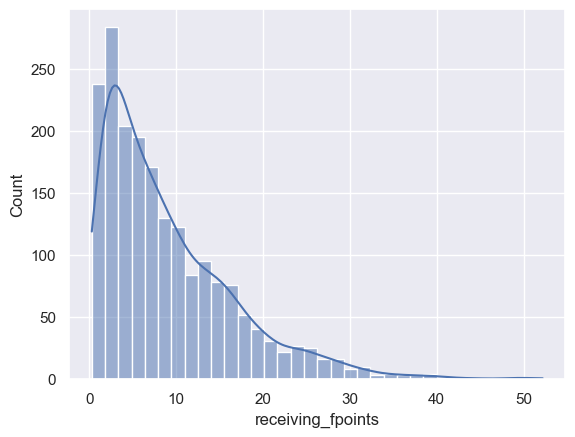

In [11]:
# should we thin out some of the lower fantasy performances?
sns.histplot(wr_stats[wr_stats['receiving_fpoints'] > 0]['receiving_fpoints'], kde=True)

In [12]:
# ADDED 6/17/2024 the last thing I want to do is just get only the top 40 performances each week, 
# first, sort by week and points
wrs = wr_stats.sort_values(by = ['week', 'receiving_fpoints'], ascending = [True, False]).copy()
wrs = wrs.groupby('week').head(40)
wrs.shape

(720, 51)

In [13]:
# since we are doing rolling windows, I need the previous two weeks as well
temp = pd.DataFrame(columns = wr_stats.columns)
for idx, row in wrs.iterrows():
    if row['week'] == 1:
        continue
    elif row['week'] == 2:
        temp = pd.concat([temp, wr_stats[(wr_stats['week'] == 1) & (wr_stats['player_id'] == row['player_id'])]], ignore_index = True)
    else:
        wk = row['week']
        temp = pd.concat([temp, wr_stats[(wr_stats['week'] == wk - 1) & (wr_stats['player_id'] == row['player_id'])]], ignore_index = True)
        temp = pd.concat([temp, wr_stats[(wr_stats['week'] == wk - 2) & (wr_stats['player_id'] == row['player_id'])]], ignore_index = True)

wrs = pd.concat([wrs, temp], ignore_index = True).sort_values(by=['player_id', 'week']).drop_duplicates()
wrs.shape

C:\Users\cbrad\AppData\Local\Temp\ipykernel_17436\967874557.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  temp = pd.concat([temp, wr_stats[(wr_stats['week'] == 1) & (wr_stats['player_id'] == row['player_id'])]], ignore_index = True)
C:\Users\cbrad\AppData\Local\Temp\ipykernel_17436\967874557.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  temp = pd.concat([temp, wr_stats[(wr_stats['week'] == wk - 1) & (wr_stats['player_id'] == row['player_id'])]], ignore_index = True)


(1162, 51)

<Axes: xlabel='receiving_fpoints', ylabel='Count'>

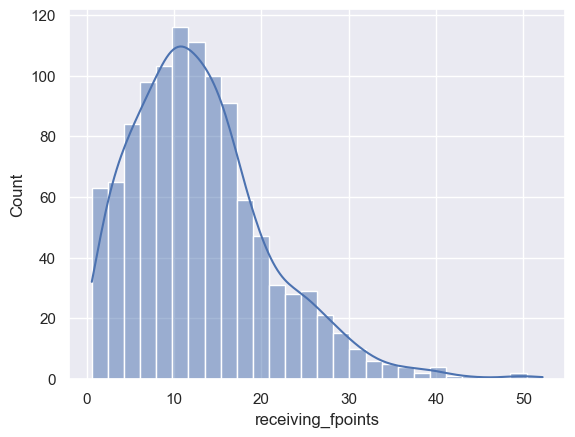

In [14]:
# this looks much better!
sns.histplot(wrs[wrs['receiving_fpoints'] > 0]['receiving_fpoints'], kde=True)

## Train, Test Split

Now that the data is clean and ready to go for ML, let's set up our testing and training data by

1. Getting windowed data so that each entry has the average of the last two weeks for features: avg yards, avg td's, etc.
2. Use SKlean to split the testing and training data

In [15]:
# now we need to get the dataset to be averages of all datapoints aside from fantasy points before the current week.
roll_window = 2

new_dataset = wrs[['player_id', 
                   'game_id', 
                   'team', 
                   'week', 
                   'position', 
                   'receiving_fpoints', 
                   'age', 
                   'height', 
                   'weight', 
                   'depth_team', 
                   'opp_team',
                   'espn_projection']]

cmas = wrs[['player_id', 'game_id', 'receiving_yards', 'avg_yac', 'receptions',
       'receiving_touchdowns', 'week', 'targets_1', 'targets_2', 'targets_3',
       'targets_4', 'total_targets', 'rz_targets', 'garbage_time_fpoints',
       'receiving_fpoints', 'avg_depth_of_target', 'air_yards',
       'max_target_depth', 'fumble_lost', 'receiving_first_downs',
       'receiving_epa', 'receiving_2pt_conversions', 'unrealized_air_yards',
       'racr', 'snap_count_1', 'snap_count_2', 'snap_count_3', 'snap_count_4',
       'total_relevant_snaps', 'snap_percentage_1',
       'snap_percentage_2', 'snap_percentage_3', 'snap_percentage',
       'target_share_1', 'target_share_2', 'target_share_3', 'target_share',
       'air_yards_share', 'wopr']].sort_values(by=['player_id', 'week'])
cmas = cmas.set_index(['game_id', 'week']).groupby(['player_id']).rolling(roll_window, min_periods=1).mean().reset_index().rename({'receiving_fpoints':'past_fpoints'}, axis=1)



In [16]:
new_dataset.shape

(1162, 12)

In [17]:
# this ensures that the new_week stat associates a players historical stats with the "current" week
# NOTE: Those with a NaN new week are players who did not play past that "week"
for idx, row in new_dataset.iterrows():
    week = row.week
    pid = row.player_id

    # most recent stats
    temp_week = cmas[(cmas.player_id == pid) & (cmas.week < week)].week.max()
    index = cmas[(cmas.player_id == pid) & (cmas.week == temp_week)].index
    cmas.loc[index, 'new_week'] = week

In [18]:
print(f"The length of the dataset pre-windowing is: {len(new_dataset)}")

The length of the dataset pre-windowing is: 1162


In [19]:
# now we merge cma stats
data = new_dataset.merge(cmas.drop('game_id', axis=1), left_on=['player_id', 'week'], right_on=['player_id', 'new_week'], suffixes = ('', '_remove'))
data.drop(['new_week'] + [x for x in data.columns if '_remove' in x], axis=1, inplace = True)
print(f"The length of the dataset post-windowing is: {len(data)}")
data.head()

The length of the dataset post-windowing is: 1024


player_id          game_id team week position  receiving_fpoints   age  \
0  00-0027944  2023_16_NYG_PHI  PHI   16       WR                1.5  35.4   
1  00-0027944  2023_17_ARI_PHI  PHI   17       WR               17.4  35.4   
2  00-0028002  2023_14_HOU_NYJ  NYJ   14       WR                8.5  33.8   
3  00-0030035   2023_02_NO_CAR  CAR    2       WR               18.4  33.8   
4  00-0030035  2023_03_CAR_SEA  CAR    3       WR               31.5  33.8   

   height  weight  depth_team  ... snap_percentage_1  snap_percentage_2  \
0    75.0   220.0         1.0  ...          0.366667           0.347826   
1    75.0   220.0         1.0  ...          0.288596           0.333004   
2    70.0   192.0         2.0  ...          0.043478           0.176471   
3    74.0   195.0         1.0  ...          0.852941           0.851852   
4    74.0   195.0         1.0  ...          0.830317           0.842593   

   snap_percentage_3  snap_percentage  target_share_1  target_share_2  \
0           0.222222         0.333333         0.00000        0.000000   
1           0.267361         0.299578         0.00000        0.100000   
2           0.111111         0.112903         0.00000        0.000000   
3           1.000000         0.886076         0.00000        0.071429   
4           1.000000         0.869267         0.15625        0.035714   

   target_share_3  target_share  air_yards_share      wopr  
0        0.000000      0.032258         0.020339  0.062624  
1        0.090909      0.067411         0.077155  0.155125  
2        0.000000      0.000000         0.000000  0.000000  
3        0.083333      0.050000         0.032028  0.097420  
4        0.223485      0.146622         0.130355  0.311181  

[5 rows x 48 columns]

### Adding Defensive and QB Stats

In [20]:
# now we need to merge in average QBR, Average Defensive Rating, and Current Defensive Injuries
def_points_allowed.sort_values(by=['team','week'], inplace=True)
qb_stats.sort_values(by=['posteam', 'passer_player_id', 'week'], inplace=True)

def_points_allowed_2 = def_points_allowed.set_index(['game_id', 'week']).groupby(['team']).rolling(roll_window, min_periods=1).mean().reset_index()
qb_stats_2 = qb_stats.set_index(['game_id', 'week', 'posteam']).groupby(['passer_player_id']).rolling(roll_window, min_periods=1).mean().reset_index()

# I need a QB's past stats but for the current starter. 
qb_starts = qb_stats_2[['passer_player_id', 'week', 'game_id', 'posteam']].copy()

In [21]:
# because we want to correlate the average of all past performances with the current 
def_points_allowed_2['week'] = def_points_allowed_2['week'] + 1

qbr = qb_starts.merge(qb_stats_2[['passer_player_id', 'week', 'QBR']], on=['passer_player_id', 'week'])
qbr.rename({'QBR':'hist_QBR'}, axis=1, inplace=True)

# We need to only keep the starters for each week (thus, if a player got injured, we wouldn't know that ahead of time)
import nfl_data_py as nfl
dc = nfl.import_depth_charts(years=[2023])
dc.drop_duplicates(inplace=True)
starter_filter = dc[(dc['position'] == 'QB') & (dc['depth_position'] == 'QB') & (dc['depth_team'] == '1') & (dc['formation'] == 'Offense') & (dc['game_type'] == 'REG') & (dc.week > 1)].rename({'gsis_id':'passer_player_id'},axis=1)
starter_filter = starter_filter.groupby([x for x in starter_filter.columns if x != 'depth_team']).agg({'depth_team':'min'})['depth_team'].reset_index()
qbr_final = starter_filter[['passer_player_id', 'week']].merge(qbr, how='left', on = ['passer_player_id', 'week'])

# now we merge cma stats
data = new_dataset.merge(cmas.drop('game_id', axis=1), 
                         how = 'left', 
                         left_on=['player_id', 'week'], 
                         right_on=['player_id', 'week'])
data2 = data.merge(def_points_allowed_2.drop(['game_id'], axis=1), 
                    how = 'left', 
                    left_on=['opp_team', 'week'],
                    right_on=['team', 'week'], 
                    suffixes=('', '_remove'))
data2.drop([i for i in data2.columns if 'remove' in i],
               axis=1, inplace=True)
data3 = data2.merge(def_injuries.drop(['game_id'], axis=1), 
                    how = 'left', 
                    left_on=['opp_team', 'week'], 
                    right_on=['team', 'week'], 
                    suffixes=('', '_remove')) \
        .rename({'num_injured_starters': 'def_inj_starters'}, axis = 1)

# now we can get QB stats
data4 = data3.merge(qbr_final.drop(['game_id'], axis=1),
                    how = 'left', 
                    left_on=['team', 'week'], 
                    right_on=['posteam', 'week'], 
                    suffixes=('', '_remove')) \
        .drop(['passer_player_id', 'posteam'], axis = 1)

# del data, data2
# defensive stats
data4.sort_values(['week', 'team']).tail()

player_id          game_id team week position  receiving_fpoints   age  \
179  00-0032211  2023_18_SEA_ARI  SEA   18       WR          15.099999  31.7   
162  00-0032128    2023_18_LA_SF   SF   18       WR           9.900000  31.6   
300  00-0033921   2023_18_TB_CAR   TB   18       WR          11.100000  28.3   
57   00-0030564  2023_18_JAX_TEN  TEN   18       WR          17.600000  32.0   
527  00-0035659  2023_18_DAL_WAS  WAS   18       WR          11.600000  28.7   

     height  weight  depth_team  ... air_yards_share      wopr  new_week  \
179    70.0   182.0         1.0  ...        0.288070  0.419086       NaN   
162    75.0   205.0         3.0  ...        0.146825  0.257950       NaN   
300    73.0   209.0         1.0  ...        0.187133  0.388136       NaN   
57     73.0   212.0         1.0  ...        0.366259  0.679064       NaN   
527    72.0   210.0         1.0  ...        0.477122  0.702520       NaN   

     total_qb_fpoints_given_up  total_rb_fpoints_given_up  \
179                      21.84                      20.84   
162                      21.96                      10.70   
300                      16.59                      26.00   
57                       11.25                      18.75   
527                      13.18                      20.30   

     total_wr_fpoints_given_up  total_te_fpoints_given_up  team_remove  \
179                      20.20                      19.95          ARI   
162                      51.45                      17.55          NaN   
300                      27.65                      12.40          NaN   
57                       35.10                       3.40          NaN   
527                      35.60                      13.70          NaN   

     def_inj_starters    hist_QBR  
179               1.0  101.001521  
162               NaN         NaN  
300               NaN   75.077712  
57                NaN         NaN  
527               NaN   57.784112  

[5 rows x 56 columns]

In [22]:
data4.drop([x for x in data4.columns if '_remove' in x], axis=1, inplace = True)
print(f"The length of the dataset post-windowing is: {len(data4)}")
# let's drop some of these high null stats
null_stats = data4.isna().sum()/data4.shape[0]
null_stats[null_stats>0].sort_values(ascending=False)

The length of the dataset post-windowing is: 1162


def_inj_starters             0.790017
espn_projection              0.351979
hist_QBR                     0.171256
total_qb_fpoints_given_up    0.119621
total_rb_fpoints_given_up    0.119621
total_wr_fpoints_given_up    0.119621
total_te_fpoints_given_up    0.119621
new_week                     0.118761
dtype: float64

In [23]:
# let's assume injured defenders is 0 when it's null
data4['def_inj_starters'] = data4['def_inj_starters'].fillna(0)

# as for the other stats, let's just fill the average
print(f"Average QB fantasy points given up across 2023: {data4['total_qb_fpoints_given_up'].mean()}")
data4['total_qb_fpoints_given_up'] = data4['total_qb_fpoints_given_up'].fillna(data4['total_qb_fpoints_given_up'].mean())
print(f"Average RB fantasy points given up across 2023: {data4['total_rb_fpoints_given_up'].mean()}")
data4['total_rb_fpoints_given_up'] = data4['total_rb_fpoints_given_up'].fillna(data4['total_rb_fpoints_given_up'].mean())
print(f"Average WR fantasy points given up across 2023: {data4['total_wr_fpoints_given_up'].mean()}")
data4['total_wr_fpoints_given_up'] = data4['total_wr_fpoints_given_up'].fillna(data4['total_wr_fpoints_given_up'].mean())
print(f"Average TE fantasy points given up across 2023: {data4['total_te_fpoints_given_up'].mean()}")
data4['total_te_fpoints_given_up'] = data4['total_te_fpoints_given_up'].fillna(data4['total_te_fpoints_given_up'].mean())
# finally fill QBR
print(f"Average QBR across 2023: {data4['hist_QBR'].mean()}")
data4['hist_QBR'] = data4['hist_QBR'].fillna(data4['hist_QBR'].mean())

Average QB fantasy points given up across 2023: 16.231876809372114
Average RB fantasy points given up across 2023: 21.4021994627699
Average WR fantasy points given up across 2023: 34.23097749049334
Average TE fantasy points given up across 2023: 11.849511221007518
Average QBR across 2023: 88.04649657577967


### split up testing and training data

In [24]:
data4["week"] = data4["week"] / 18
data4["depth_team"] = data4["depth_team"] / 3
drop_list = ['receiving_fpoints', 
             'espn_projection',
             'new_week',
             'player_id', 
             'game_id', 
             'team', 
             'opp_team', 
             'position', 
             'total_te_fpoints_given_up', 
             'total_qb_fpoints_given_up', 
             'total_rb_fpoints_given_up',
             'original_index']
data4 = data4.reset_index().rename({'index':'original_index'}, axis=1)

X_train, X_test, y_train,y_test = train_test_split(data4.drop(drop_list, axis=1), 
                                                                        data4['receiving_fpoints'], 
                                                                        test_size = 0.33, 
                                                                        random_state = 42)

# scaling
non_scale_list = [
                    "week",
                    "depth_team",
                    "snap_percentage_1",
                    "snap_percentage_2",
                    "snap_percentage_3",
                    "target_share",
                    "air_yards_share",
                    "target_share_1",
                    "target_share_2",
                    "target_share_3",
                    "target_share_1",
                    "wopr",
                    "def_inj_starters"
                ]
# columns you don't need to scale:
scale_list = [
    x
    for x in data4.columns
    if x
    not in non_scale_list + drop_list
]


feature_list = scale_list + non_scale_list

# scale train data
X_train_2 = X_train[scale_list]
leftover_train = np.asarray(
            X_train[non_scale_list]
        )
y_train_s = np.asarray(y_train)

train_scaler = StandardScaler()
X_train_s = train_scaler.fit_transform(X=X_train_2)
X_train_s_all = np.concatenate((X_train_s, leftover_train), axis=1)

# scale test data
X_test_2 = X_test[scale_list]
leftover_test = np.asarray(
            X_test[non_scale_list]
        )
y_test_s = np.asarray(y_test)

test_scaler = StandardScaler()
X_test_s = test_scaler.fit_transform(X=X_test_2)
X_test_s_all = np.concatenate((X_test_s, leftover_test), axis=1)

print(f"shape1 {X_train_s.shape}, shape2: {X_train_s_all.shape}")

shape1 (778, 32), shape2: (778, 45)


## Let's do some machine learning

In [25]:
# let's train a simple regression model to see how we do
reg = LinearRegression()
cross_val_score(reg, X_train_s_all, y_train_s, scoring='neg_mean_absolute_error', cv=3)

array([-3.05568663, -3.43372136, -3.05100969])

In [26]:
reg.fit(X_train_s_all, y_train_s)
y_pred_reg = reg.predict(X_test_s_all)
print(f"MAE: {mean_absolute_error(np.asarray(y_test), y_pred_reg)}")

MAE: 4.050164418819137


In [27]:
def get_test_results(test_target, preds, id_map, init_data):
    results = pd.DataFrame(test_target)
    results['yhat'] = preds
    results = results.merge(id_map, how = 'left', left_index = True, right_index = True)
    results = results.merge(init_data, how = 'left', on=['player_id', 'game_id'])
    return results


In [28]:
reg1_test_results = get_test_results(test_target = y_test, 
                                     preds = y_pred_reg,
                                     id_map = data4[['player_id', 'game_id']], 
                                     init_data = wrs[['player_id', 
                                                     'game_id', 
                                                     'player_name', 
                                                     'receiving_yards', 
                                                     'receptions', 
                                                     'receiving_touchdowns', 
                                                     'week', 
                                                     'fumble_lost',
                                                     'espn_projection']])
reg1_test_results.head()

receiving_fpoints       yhat   player_id          game_id      player_name  \
0                5.6  14.507623  00-0033307   2023_04_NE_DAL  Kendrick Bourne   
1               20.2  14.570094  00-0031408   2023_07_ATL_TB       Mike Evans   
2                6.0   7.816087  00-0038997  2023_01_JAX_IND       Josh Downs   
3               22.5   9.841206  00-0036196  2023_12_BUF_PHI       Gabe Davis   
4                8.9   9.839621  00-0036912  2023_07_MIA_PHI    DeVonta Smith   

   receiving_yards  receptions  receiving_touchdowns week  fumble_lost  \
0             36.0         2.0                   0.0    4          0.0   
1             82.0         6.0                   1.0    7          0.0   
2             30.0         3.0                   0.0    1          0.0   
3            105.0         6.0                   1.0   12          0.0   
4             49.0         4.0                   0.0    7          0.0   

   espn_projection  
0        11.067116  
1        15.883892  
2              NaN  
3         9.921391  
4        14.713914

In [29]:
# how did ESPN do?
y_espn = np.asarray(reg1_test_results[~reg1_test_results['espn_projection'].isna()]['receiving_fpoints'])
yhat_espn = np.asarray(reg1_test_results[~reg1_test_results['espn_projection'].isna()]['espn_projection'])
perc_filled_espn = reg1_test_results[~reg1_test_results['espn_projection'].isna()].shape[0]/reg1_test_results.shape[0]
print(f"ESPN MAE: {mean_absolute_error(y_espn, yhat_espn)}. ESPN projections are {perc_filled_espn:.2%} of records.")

ESPN MAE: 6.315792394032336. ESPN projections are 63.80% of records.


In [30]:
# maybe we have a dimensionality problem. Let's just grab some predictive features
# high variance also probably means we don't have enough data
feature_idx_list = (feature_list.index('past_fpoints'), feature_list.index('receiving_first_downs'), feature_list.index('wopr'), feature_list.index('racr'))
X_train_sub = X_train_s_all[:, feature_idx_list]
cross_val_score(reg, X_train_sub, y_train_s, scoring='neg_mean_absolute_error', cv=3)

array([-3.16219707, -3.07237387, -2.91117601])

In [31]:
# that's a little better
reg.fit(X_train_sub, y_train_s)
X_test_sub = X_test_s_all[:, feature_idx_list]
y_pred_reg = reg.predict(X_test_sub)
print(f"MAE: {mean_absolute_error(y_test_s, y_pred_reg)}")
print(f"ESPN MAE: {mean_absolute_error(y_espn, yhat_espn)}. ESPN projections are {perc_filled_espn:.2%} of records.")

MAE: 3.7655650906396017
ESPN MAE: 6.315792394032336. ESPN projections are 63.80% of records.


In [32]:
reg2_test_results = get_test_results(test_target = y_test, 
                                     preds = y_pred_reg,
                                     id_map = data4[['player_id', 'game_id']], 
                                     init_data = wrs[['player_id', 
                                                     'game_id', 
                                                     'player_name', 
                                                     'receiving_yards', 
                                                     'receptions', 
                                                     'receiving_touchdowns', 
                                                     'week', 
                                                     'fumble_lost',
                                                     'espn_projection']])
reg2_test_results.head()

receiving_fpoints       yhat   player_id          game_id      player_name  \
0                5.6  15.614877  00-0033307   2023_04_NE_DAL  Kendrick Bourne   
1               20.2  15.005538  00-0031408   2023_07_ATL_TB       Mike Evans   
2                6.0   6.498552  00-0038997  2023_01_JAX_IND       Josh Downs   
3               22.5  11.811142  00-0036196  2023_12_BUF_PHI       Gabe Davis   
4                8.9   9.508211  00-0036912  2023_07_MIA_PHI    DeVonta Smith   

   receiving_yards  receptions  receiving_touchdowns week  fumble_lost  \
0             36.0         2.0                   0.0    4          0.0   
1             82.0         6.0                   1.0    7          0.0   
2             30.0         3.0                   0.0    1          0.0   
3            105.0         6.0                   1.0   12          0.0   
4             49.0         4.0                   0.0    7          0.0   

   espn_projection  
0        11.067116  
1        15.883892  
2              NaN  
3         9.921391  
4        14.713914

In [33]:
# we could look at random forest as well
rf = RandomForestRegressor(max_depth=4, n_jobs = -1, random_state = 42)
cross_val_score(reg, X_train_s_all, y_train_s, scoring='neg_mean_absolute_error', cv=3)

array([-3.05568663, -3.43372136, -3.05100969])

In [34]:
rf.fit(X_train_s_all, y_train_s)

# get predictions
y_pred = rf.predict(X_test_s_all)
print(f"MAE: {mean_absolute_error(y_test_s, y_pred)}")
print(f"ESPN MAE: {mean_absolute_error(y_espn, yhat_espn)}. ESPN projections are {perc_filled_espn:.2%} of records.")

MAE: 3.844599789059197
ESPN MAE: 6.315792394032336. ESPN projections are 63.80% of records.


In [35]:
rf_test_results = get_test_results(test_target = y_test, 
                                     preds = y_pred,
                                     id_map = data4[['player_id', 'game_id']], 
                                     init_data = wrs[['player_id', 
                                                     'game_id', 
                                                     'player_name', 
                                                     'receiving_yards', 
                                                     'receptions', 
                                                     'receiving_touchdowns', 
                                                     'week', 
                                                     'fumble_lost',
                                                     'espn_projection']])
rf_test_results.head()

receiving_fpoints       yhat   player_id          game_id      player_name  \
0                5.6  15.250005  00-0033307   2023_04_NE_DAL  Kendrick Bourne   
1               20.2  15.303757  00-0031408   2023_07_ATL_TB       Mike Evans   
2                6.0   7.773506  00-0038997  2023_01_JAX_IND       Josh Downs   
3               22.5  11.826445  00-0036196  2023_12_BUF_PHI       Gabe Davis   
4                8.9   8.590796  00-0036912  2023_07_MIA_PHI    DeVonta Smith   

   receiving_yards  receptions  receiving_touchdowns week  fumble_lost  \
0             36.0         2.0                   0.0    4          0.0   
1             82.0         6.0                   1.0    7          0.0   
2             30.0         3.0                   0.0    1          0.0   
3            105.0         6.0                   1.0   12          0.0   
4             49.0         4.0                   0.0    7          0.0   

   espn_projection  
0        11.067116  
1        15.883892  
2              NaN  
3         9.921391  
4        14.713914

Text(0.5, 0, 'Mean decrease in impurity')

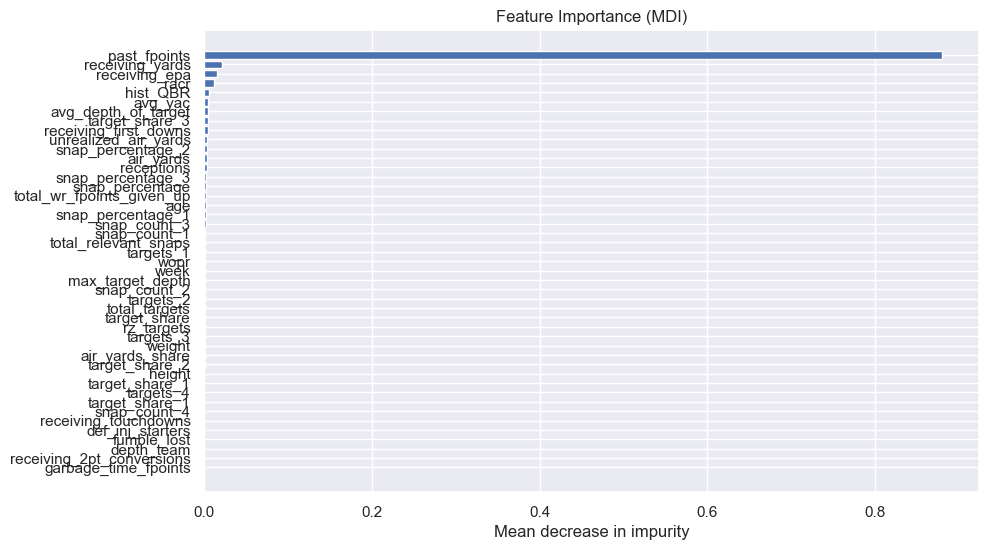

In [36]:
# obtain feature importance
feature_importance = rf.feature_importances_

# sort features according to importance
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0])

# plot feature importances
fig,ax = plt.subplots(figsize=(10,6))

ax.barh(pos, feature_importance[sorted_idx], align="center")

ax.set_yticks(pos, np.array(feature_list)[sorted_idx])
ax.set_title("Feature Importance (MDI)")
ax.set_xlabel("Mean decrease in impurity")

In [37]:
# finally, let's look at XGBoost
xgb = XGBRegressor(max_depth=4, n_jobs = -1, random_state = 42)
cross_val_score(reg, X_train_s_all, y_train_s, scoring='neg_mean_absolute_error', cv=3)

array([-3.05568663, -3.43372136, -3.05100969])

In [38]:
xgb.fit(X_train_s_all, y_train_s)

# get predictions
y_pred = xgb.predict(X_test_s_all)
print(f"MAE: {mean_absolute_error(y_test_s, y_pred)}")
print(f"ESPN MAE: {mean_absolute_error(y_espn, yhat_espn)}. ESPN projections are {perc_filled_espn:.2%} of records.")

MAE: 4.280404116027057
ESPN MAE: 6.315792394032336. ESPN projections are 63.80% of records.


In [39]:
xgb_test_results = get_test_results(test_target = y_test, 
                                     preds = y_pred,
                                     id_map = data4[['player_id', 'game_id']], 
                                     init_data = wrs[['player_id', 
                                                     'game_id', 
                                                     'player_name', 
                                                     'receiving_yards', 
                                                     'receptions', 
                                                     'receiving_touchdowns', 
                                                     'week', 
                                                     'fumble_lost',
                                                     'espn_projection']])
xgb_test_results.sort_values(by=['yhat', 'player_id'], ascending = [False, False]).head()

receiving_fpoints       yhat   player_id          game_id    player_name  \
221          27.600000  42.658195  00-0030279   2023_11_LAC_GB   Keenan Allen   
369          52.200001  41.123978  00-0036900  2023_05_CIN_ARI  Ja'Marr Chase   
26           39.500001  37.706638  00-0030279  2023_03_LAC_MIN   Keenan Allen   
91           28.100001  35.337845  00-0036358  2023_09_DAL_PHI    CeeDee Lamb   
15           39.700001  34.878414  00-0036358  2023_17_DET_DAL    CeeDee Lamb   

     receiving_yards  receptions  receiving_touchdowns week  fumble_lost  \
221            116.0        10.0                   1.0   11          0.0   
369            192.0        15.0                   3.0    5          0.0   
26             215.0        18.0                   0.0    3          0.0   
91             191.0        11.0                   0.0    9          1.0   
15             227.0        13.0                   1.0   17          1.0   

     espn_projection  
221        18.516343  
369        20.646237  
26         16.249075  
91         18.966567  
15         23.001908

### Commentary

These models all perform very similarly. XGBoost is generally considered to be the best ML method in this genre, so we should definitely keep it as a contender. Let's check the baseline on all of these models and see where we land. From there, we can pick 2 or 3 and optimize hyperparameters to see where we can get. The hyperparameters to optimize are:

1. $n_p$ - The number of top performing players we keep in our training set.
2. $t_w$ - The number of days we take the average of for the training set (i.e. we take the average of the past two days fantasy points, recieving yards, etc.)
3. $\{f_i\}$ - The set of features we use to train the model: $f_0, f_1, f_2, ..., f_m$
4. Any model specific parameters.

### Some things we need to do:

1. Let's first grab some expert predictions in order to properly assess our model. Build out in Data Pull program DONE
2. Weather data. Build out in Data Pull program

## Baseline Model

Let's establish a baseline model that predicts last weeks performance as this weeks performace. In the 
case where there is no performance last week, the model will (for now) just grab the global average. 

In [ ]:
# first let's establish a baseline model
def baseline_model(y, id_map, init_data):
    # grab results datafrmae
    results = pd.DataFrame(y)
    results = results.merge(id_map, how = 'left', left_index = True, right_index = True)
    results = results.merge(init_data.drop('receiving_fpoints',axis=1), how = 'left', on=['player_id', 'game_id'])
    
    prev_data = init_data[['player_id', 'week', 'receiving_fpoints']].copy().rename({'receiving_fpoints':'yhat'},axis=1)
    prev_data['week'] = prev_data['week'] + 1

    results = results.merge(prev_data, how='left', on=['player_id', 'week'])
    # if there was no data for the previous week, just predict the average. 
    # NOTE: This is probably bad practice since I am feeding information about the test set to the model, 
    # but there's no learning happening hear so I'm not worried about fitting issues.
    results['yhat'] = results['yhat'].fillna(init_data['receiving_fpoints'].mean())
    return results[['week',
                    'game_id', 
                    'player_id', 
                    'player_name',
                   'receiving_fpoints',
                    'yhat',
                    'espn_projection',
                    'receiving_yards', 
                     'receptions', 
                     'receiving_touchdowns',
                    'fumble_lost']]

baseline_test_results = baseline_model(y = y_test, 
                                     id_map = data4[['player_id', 'game_id']], 
                                     init_data = wrs[['player_id', 
                                                     'game_id', 
                                                     'player_name', 
                                                     'receiving_yards', 
                                                     'receptions', 
                                                     'receiving_touchdowns', 
                                                     'week', 
                                                     'fumble_lost',
                                                     'espn_projection',
                                                     'receiving_fpoints']])

In [ ]:
baseline_test_results.head()

In [ ]:
# get predictions
print(f"MAE: {mean_absolute_error(baseline_test_results['receiving_fpoints'], baseline_test_results['yhat'])}")
print(f"ESPN MAE: {mean_absolute_error(y_espn, yhat_espn)}. ESPN projections are {perc_filled_espn:.2%} of records.")

## Tuning XGBoost

Let's get the optimal XGBoost model.

In [47]:
# let's quickly see how good we can get XGBoost to predict
from xgboost import DMatrix, cv
import matplotlib.pyplot as plt

def modelfit(model, X, y, X_test, y_test, cols, useTrainCV=True, cv_folds=5, early_stopping_rounds=100, plot = False):

    cvresult = None
    if useTrainCV:
        xgb_param = model.get_xgb_params()
        xgtrain = DMatrix(X, label=y)
        cvresult = cv(xgb_param, xgtrain, num_boost_round=model.get_params()['n_estimators'], nfold=cv_folds,
            metrics='mae', early_stopping_rounds=early_stopping_rounds)
        model.set_params(n_estimators=cvresult.shape[0])
        print(f"n_estimators: {cvresult.shape[0]}")
    
    #Fit the algorithm on the data
    evalset = [(X, y), (X_test, y_test)]
    _ = model.fit(X, y, eval_set = evalset, verbose=False)
        
    #Predict training set:
    predictions = model.predict(X)
    # dtrain_predprob = alg.predict_proba(y)[:,1]
        
    #Print model report:
    print("\nModel Report\n-------- TRAIN --------")
    print("MAE : %.4g" % mean_absolute_error(y, predictions))
    print("R2: %f" % r2_score(y, predictions))

    #Predict training set:
    predictions_test = model.predict(X_test)
    # dtrain_predprob = alg.predict_proba(y)[:,1]
    
    print("\nModel Report\n-------- TEST --------")
    print("MAE : %.4g" % mean_absolute_error(y_test, predictions_test))
    print("R2: %f" % r2_score(y_test, predictions_test))   

    if plot:
        fix, ax = plt.subplots(2,1,figsize = (10,10))
        
        feat_imp = pd.DataFrame(list(zip(cols, model.feature_importances_)), columns = ['Feature', 'Score']) \
            .sort_values(by='Score', ascending=True) \
            .set_index('Feature')
        feat_imp.plot(title='Feature Importances', ax = ax[0], kind='barh')
        ax[0].set_xlabel('Feature Importance Score')

        results = model.evals_result()
        # plot learning curves
        ax[1].plot(results['validation_0']['mean_absolute_error'], label='train')
        ax[1].plot(results['validation_1']['mean_absolute_error'], label='test')
        # show the legend
        ax[1].set_ylabel('Mean Absolute Error')
        ax[1].set_xlabel('Epoch')
        ax[1].legend()

    return model, cvresult


n_estimators: 26

Model Report
-------- TRAIN --------
MAE : 2.647
R2: 0.831240

Model Report
-------- TEST --------
MAE : 4.032
R2: 0.596462


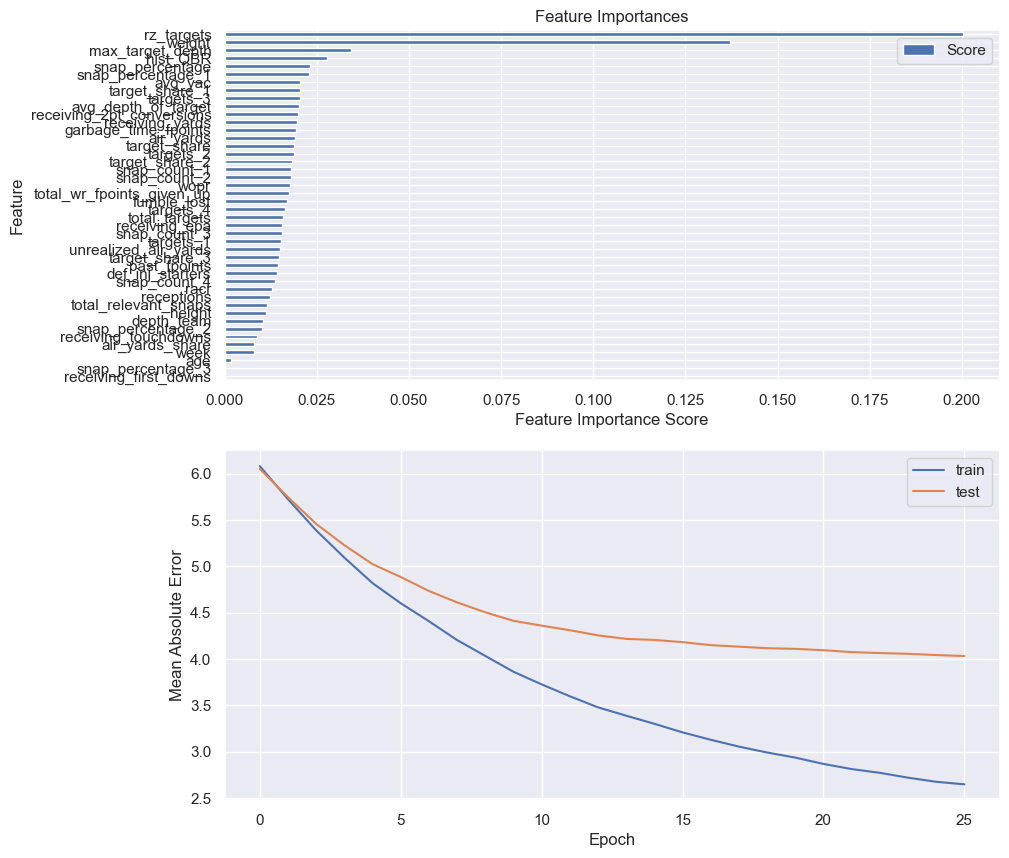

In [92]:
xgb = XGBRegressor(
    n_estimators = 1_000,
    max_depth = 5,
    max_leaves = 0,
    n_jobs = -1,
    eval_metric=mean_absolute_error,
    subsample = 0.8,
    gamma = 0,
    colsample_bytree = 0.8,
    learning_rate = 0.1,
    min_child_weight = 1
)

xgb, cv_results = modelfit(model = xgb, 
                           X = X_train_s_all, 
                           y = y_train_s, 
                           X_test = X_test_s_all, 
                           y_test = y_test_s, 
                           cols = X_train.columns.tolist(),
                           plot = True)

In [93]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
xgb = XGBRegressor(learning_rate = 0.1, 
                     n_estimators = 30,  
                     gamma = 0, 
                     subsample = 0.8, 
                     colsample_bytree = 0.8,
                     eval_metric = mean_absolute_error,
                     n_jobs = -1, 
                     seed = 27)

gsearch1 = GridSearchCV(estimator = xgb,
                        param_grid = param_test1, 
                        scoring = 'neg_mean_absolute_error',
                        cv = 3)

gsearch1.fit(X_train_s_all,y_train_s)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    device=None, early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric=<function mean_absolute_error at 0x00000200F98A1120>,
                                    feature_types=None, gamma=0,
                                    grow_policy=None, importance_type=None,
                                    interact...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=30,
                                    n_jobs=-1, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'max_depth': range(3, 10, 2),
                         'min_child_weight': range(1, 6, 2)},
             scoring='neg_mean_absolute_error')

{'max_depth': 3, 'min_child_weight': 5}
-4.033231524976926
n_estimators: 30

Model Report
-------- TRAIN --------
MAE : 3.415
R2: 0.712441

Model Report
-------- TEST --------
MAE : 3.994
R2: 0.600878


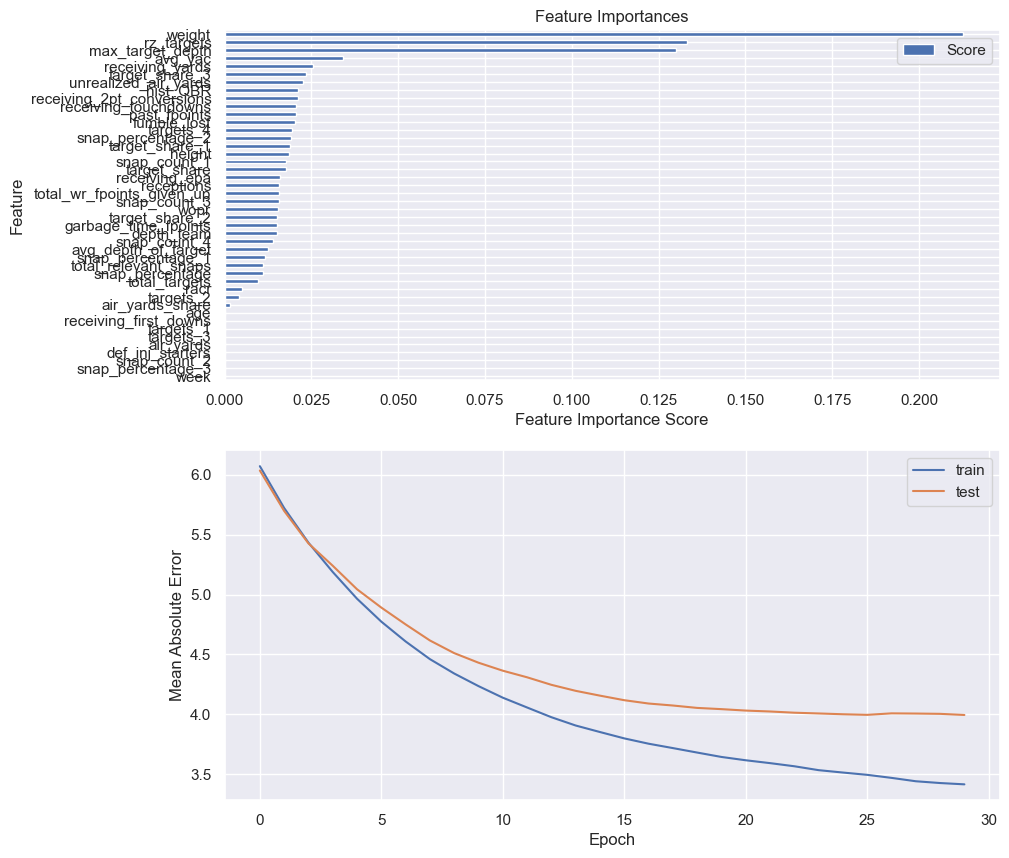

In [94]:
print(gsearch1.best_params_)
print(gsearch1.best_score_)

_, _ = modelfit(model = gsearch1.best_estimator_, 
                           X = X_train_s_all, 
                           y = y_train_s, 
                           X_test = X_test_s_all, 
                           y_test = y_test_s, 
                           cols = X_train.columns.tolist(),
                           plot = True)

In [95]:
param_test2 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

xgb = XGBRegressor(learning_rate = 0.1, 
                     n_estimators = 30, 
                     subsample = 0.8, 
                     max_depth = 3,
                     min_child_weight = 5,
                     colsample_bytree = 0.8,
                     eval_metric = mean_absolute_error,
                     n_jobs = -1, 
                     seed = 27)

gsearch2 = GridSearchCV(estimator = xgb,
                        param_grid = param_test2, 
                        scoring = 'neg_mean_absolute_error',
                        cv = 3)

gsearch2.fit(X_train_s_all,y_train_s)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    device=None, early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric=<function mean_absolute_error at 0x00000200F98A1120>,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    inter...
                                    learning_rate=0.1, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=3, max_leaves=None,
                                    min_child_weight=5, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=30,
                                    n_jobs=-1, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
             scoring='neg_mean_absolute_error')

{'gamma': 0.0}
-4.033231524976926
n_estimators: 30

Model Report
-------- TRAIN --------
MAE : 3.415
R2: 0.712441

Model Report
-------- TEST --------
MAE : 3.994
R2: 0.600878


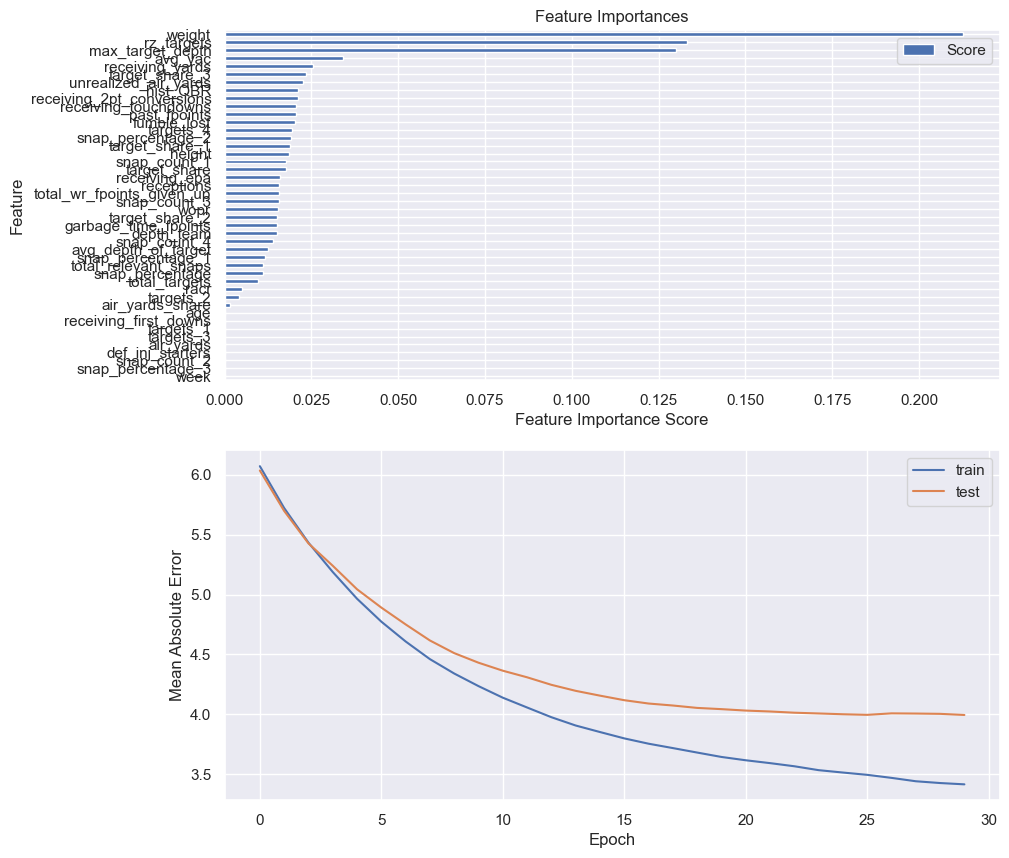

In [96]:
print(gsearch2.best_params_)
print(gsearch2.best_score_)

_, _ = modelfit(model = gsearch2.best_estimator_, 
                           X = X_train_s_all, 
                           y = y_train_s, 
                           X_test = X_test_s_all, 
                           y_test = y_test_s, 
                           cols = X_train.columns.tolist(),
                           plot = True)

In [97]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

xgb = XGBRegressor(learning_rate = 0.1, 
                     n_estimators = 30, 
                     subsample = 0.8, 
                     max_depth = 3,
                     gamma = 0,
                     min_child_weight = 5,
                     colsample_bytree = 0.8,
                     eval_metric = mean_absolute_error,
                     n_jobs = -1, 
                     seed = 27)

gsearch3 = GridSearchCV(estimator = xgb,
                        param_grid = param_test4, 
                        scoring = 'neg_mean_absolute_error',
                        cv = 3)

gsearch3.fit(X_train_s_all,y_train_s)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    device=None, early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric=<function mean_absolute_error at 0x00000200F98A1120>,
                                    feature_types=None, gamma=0,
                                    grow_policy=None, importance_type=None,
                                    interact...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=3, max_leaves=None,
                                    min_child_weight=5, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=30,
                                    n_jobs=-1, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
                         'subsample': [0.6, 0.7, 0.8, 0.9]},
             scoring='neg_mean_absolute_error')

{'colsample_bytree': 0.7, 'subsample': 0.9}
-3.987267210115101
n_estimators: 30

Model Report
-------- TRAIN --------
MAE : 3.384
R2: 0.715226

Model Report
-------- TEST --------
MAE : 3.964
R2: 0.601359


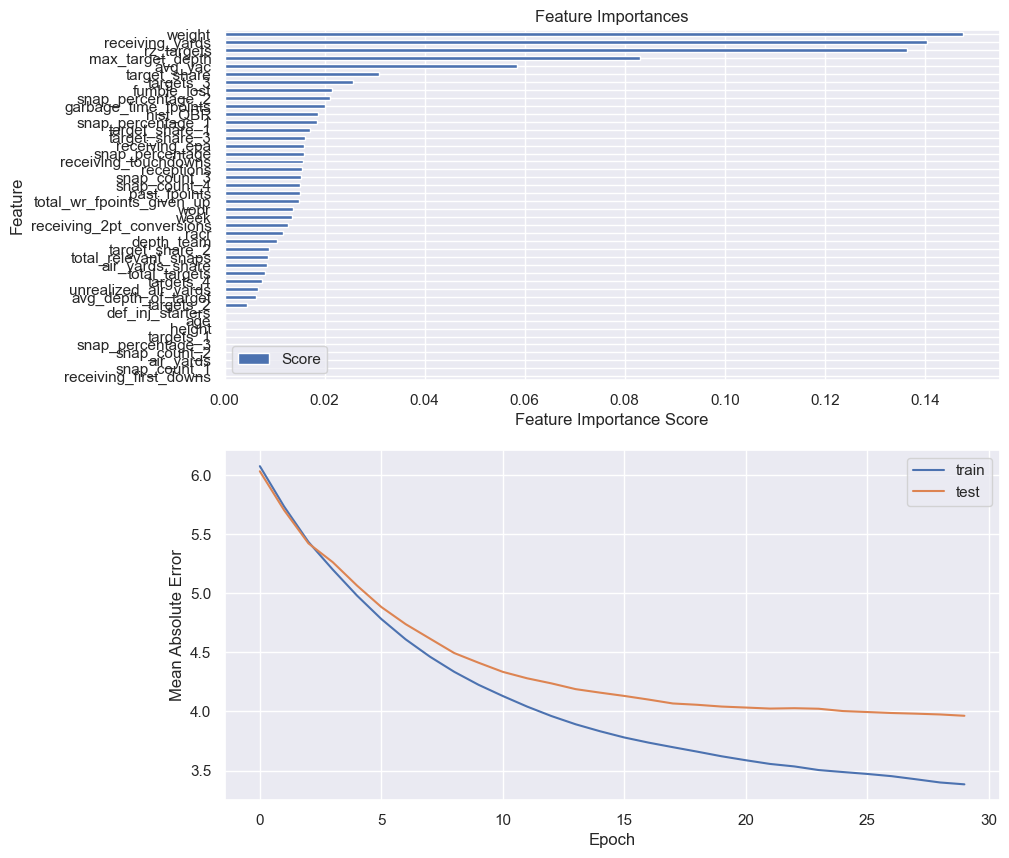

In [98]:
print(gsearch3.best_params_)
print(gsearch3.best_score_)

_, _ = modelfit(model = gsearch3.best_estimator_, 
                           X = X_train_s_all, 
                           y = y_train_s, 
                           X_test = X_test_s_all, 
                           y_test = y_test_s, 
                           cols = X_train.columns.tolist(),
                           plot = True)

n_estimators: 310

Model Report
-------- TRAIN --------
MAE : 3.383
R2: 0.715802

Model Report
-------- TEST --------
MAE : 3.954
R2: 0.607303


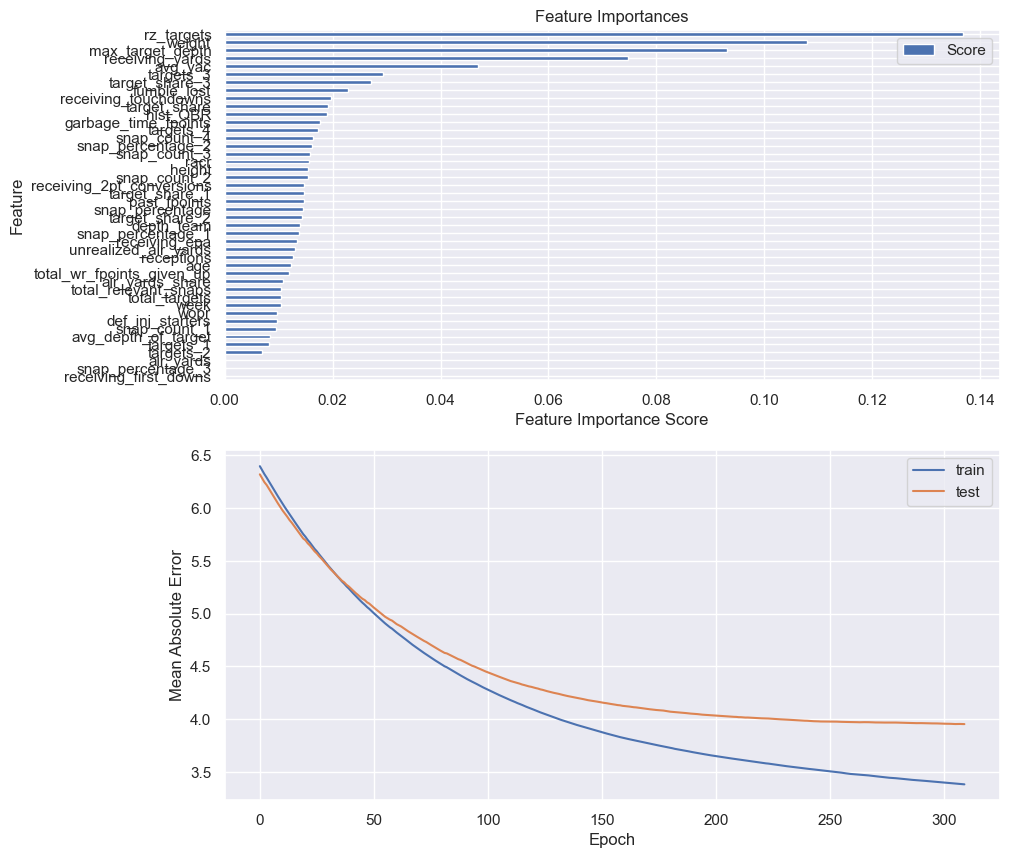

In [101]:
xgb = XGBRegressor(learning_rate = 0.01, 
                     n_estimators = 2000, 
                     subsample = 0.9, 
                     max_depth = 3,
                     gamma = 0,
                     min_child_weight = 5,
                     colsample_bytree = 0.7,
                     eval_metric = mean_absolute_error,
                     n_jobs = -1,
                     reg_lambda = 1,
                     seed = 27)

xgb, cv_results = modelfit(model = xgb, 
                           X = X_train_s_all, 
                           y = y_train_s, 
                           X_test = X_test_s_all, 
                           y_test = y_test_s, 
                           cols = X_train.columns.tolist(),
                           plot = True)

In [103]:
# get predictions
y_pred = xgb.predict(X_test_s_all)
print(f"MAE: {mean_absolute_error(y_test_s, y_pred)}")
print(f"ESPN MAE: {mean_absolute_error(y_espn, yhat_espn)}. ESPN projections are {perc_filled_espn:.2%} of records.")

MAE: 3.953987654453764
ESPN MAE: 6.315792394032336. ESPN projections are 63.80% of records.


In [104]:
xgb_test_results = get_test_results(test_target = y_test, 
                                     preds = y_pred,
                                     id_map = data4[['player_id', 'game_id']], 
                                     init_data = wrs[['player_id', 
                                                     'game_id', 
                                                     'player_name', 
                                                     'receiving_yards', 
                                                     'receptions', 
                                                     'receiving_touchdowns', 
                                                     'week', 
                                                     'fumble_lost',
                                                     'espn_projection']])
xgb_test_results.sort_values(by=['yhat', 'player_id'], ascending = [False, False]).head()

receiving_fpoints       yhat   player_id          game_id    player_name  \
221          27.600000  38.407291  00-0030279   2023_11_LAC_GB   Keenan Allen   
369          52.200001  37.575504  00-0036900  2023_05_CIN_ARI  Ja'Marr Chase   
26           39.500001  37.300949  00-0030279  2023_03_LAC_MIN   Keenan Allen   
91           28.100001  33.848946  00-0036358  2023_09_DAL_PHI    CeeDee Lamb   
164          14.000000  33.759312  00-0036900  2023_06_SEA_CIN  Ja'Marr Chase   

     receiving_yards  receptions  receiving_touchdowns week  fumble_lost  \
221            116.0        10.0                   1.0   11          0.0   
369            192.0        15.0                   3.0    5          0.0   
26             215.0        18.0                   0.0    3          0.0   
91             191.0        11.0                   0.0    9          1.0   
164             80.0         6.0                   0.0    6          0.0   

     espn_projection  
221        18.516343  
369        20.646237  
26         16.249075  
91         18.966567  
164        21.658997

## Tuning Regression

That's still not better than our regression model! Let's see how well we can get regression to run.

In [109]:
# let's quickly get a baseline
reg = LinearRegression()
cross_val_score(reg, X_train_s_all, y_train_s, scoring='neg_mean_absolute_error', cv=3)

array([-3.8033363 , -4.40200028, -3.87736837])

In [114]:
# get testing scores
reg.fit(X_train_s_all, y_train_s)
y_pred_reg = reg.predict(X_test_s_all)
print(f"MAE: {mean_absolute_error(y_test_s, y_pred_reg)}")
print(f"ESPN MAE: {mean_absolute_error(y_espn, yhat_espn)}. {perc_filled_espn:.2%} of records have ESPN projections.")

MAE: 4.050164418819137
ESPN MAE: 6.315792394032336. 63.80% of records have ESPN projections.


<Axes: >

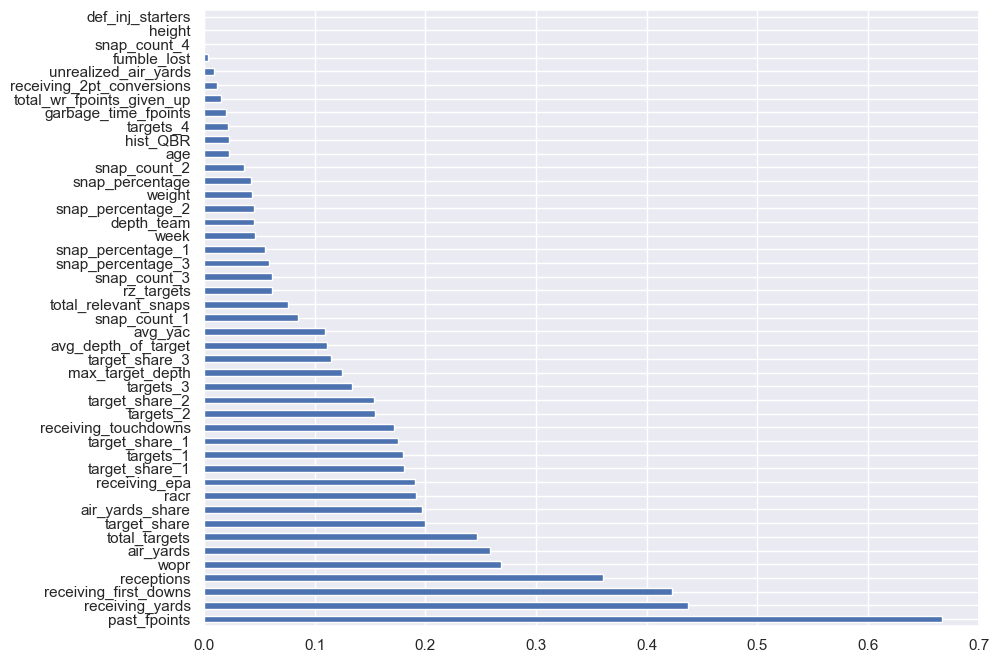

In [127]:
# let's intelligently select features
from sklearn.feature_selection import mutual_info_regression, RFE

importances = mutual_info_regression(X_train_s_all, y_train_s)
feat_importances = pd.Series(importances, feature_list).sort_values(ascending=False)
fig,ax=plt.subplots(figsize=(10,8))
feat_importances.plot(kind='barh', ax=ax)

In [116]:
# RFE
estimator = LinearRegression()
rfe = RFE(estimator, n_features_to_select=10)
rfe.fit(X_train_s_all, y_train_s)
y_pred = rfe.predict(X_test_s_all)

In [117]:
# get testing scores
print(f"MAE: {mean_absolute_error(y_test_s, y_pred)}")
print(f"ESPN MAE: {mean_absolute_error(y_espn, yhat_espn)}. {perc_filled_espn:.2%} of records have ESPN projections.")

MAE: 3.78323834860261
ESPN MAE: 6.315792394032336. 63.80% of records have ESPN projections.


In [123]:
feats = []
for idx, rank in enumerate(rfe.ranking_):
    if rank == 1:
        feats.append(feature_list[idx])
        print(feature_list[idx])

receiving_yards
past_fpoints
snap_percentage
snap_percentage_1
snap_percentage_2
snap_percentage_3
target_share
air_yards_share
target_share_2
wopr


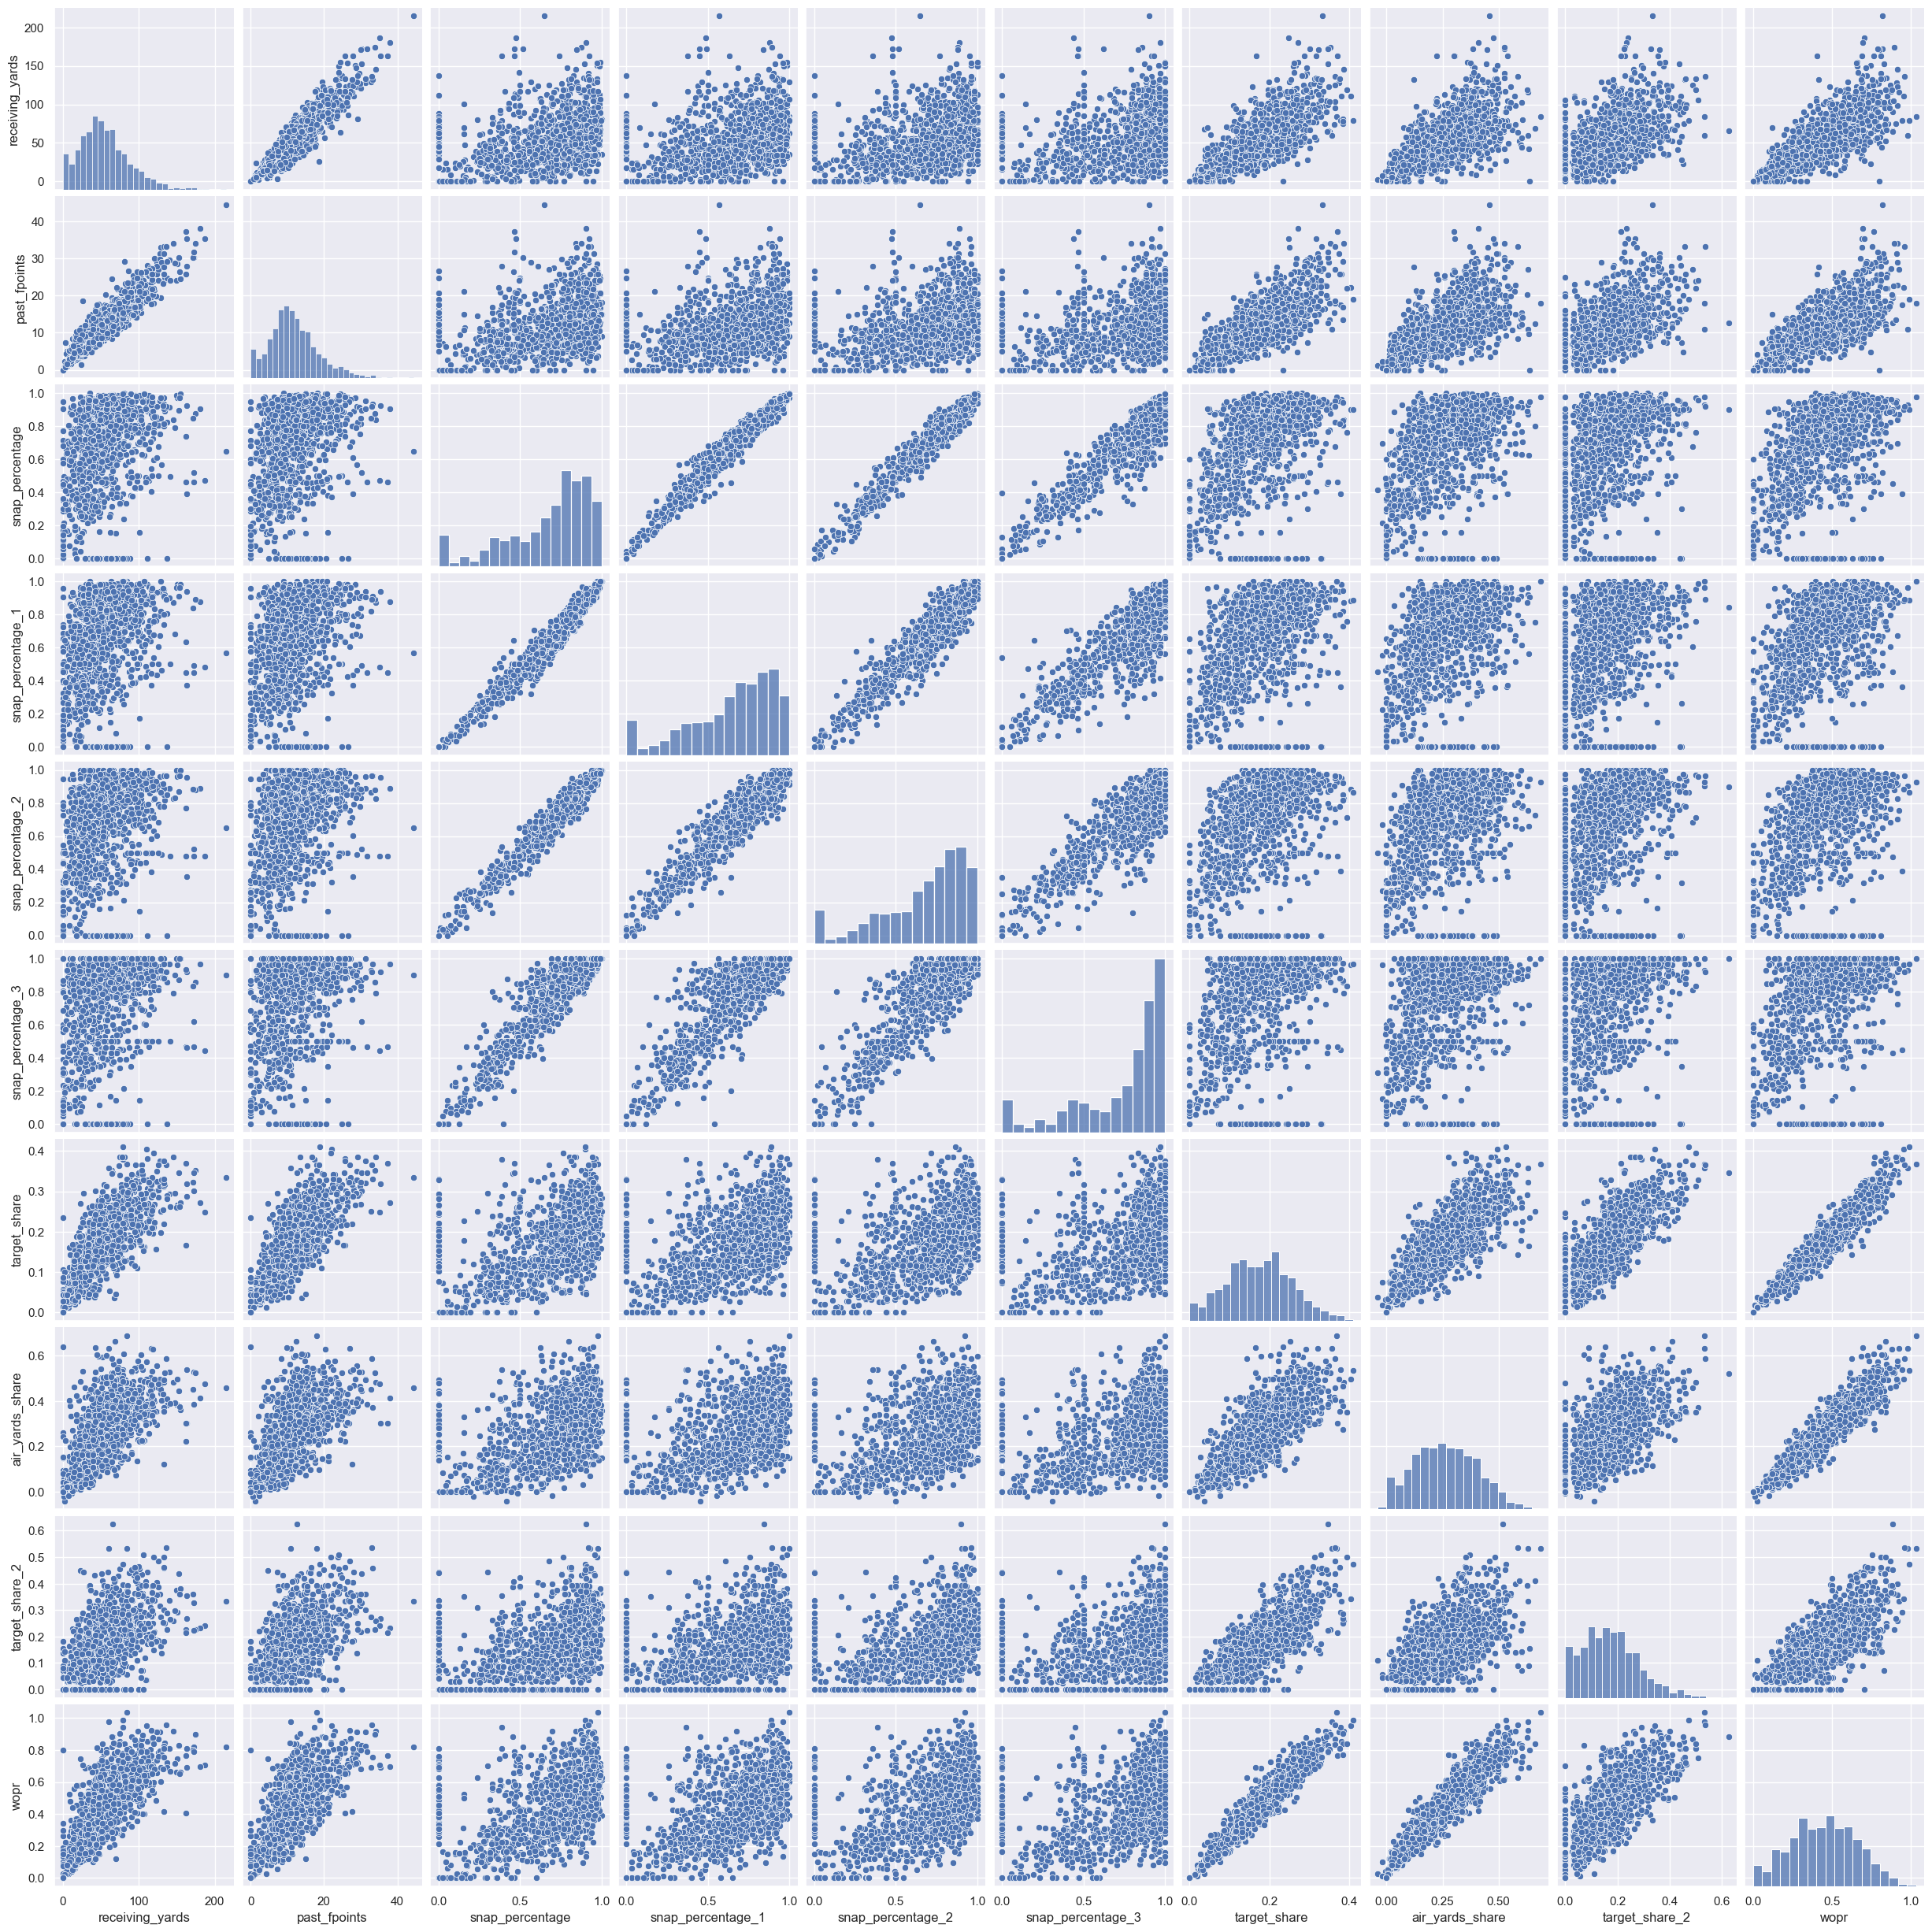

In [124]:
# let's look at the colinearity between these features
# my intuition is that the mutual_info_reg features are better
sns.pairplot(data4[feats])

In [131]:
# intuition confirmed! Snap percentage is highly coorelated with snap_percentage_1, 2 and 3.
# let's go with the first ten features from the first selection
feat_importances.head(10)

past_fpoints             0.667030
receiving_yards          0.437397
receiving_first_downs    0.422437
receptions               0.360324
wopr                     0.268519
air_yards                0.258256
total_targets            0.246484
target_share             0.199430
air_yards_share          0.196725
racr                     0.191388
dtype: float64

In [137]:
feature_idx_list = tuple(feature_list.index(x) for x in feat_importances.head(10).index.tolist())
X_train_sub = X_train_s_all[:, feature_idx_list]
cross_val_score(reg, X_train_sub, y_train_s, scoring='neg_mean_absolute_error', cv=3)

array([-3.71294404, -4.07560697, -3.7078287 ])

In [138]:
# get testing scores
reg.fit(X_train_sub, y_train_s)
y_pred_reg = reg.predict(X_test_s_all[:, feature_idx_list])
print(f"MAE: {mean_absolute_error(y_test_s, y_pred_reg)}")
print(f"ESPN MAE: {mean_absolute_error(y_espn, yhat_espn)}. {perc_filled_espn:.2%} of records have ESPN projections.")

MAE: 3.76028865337136
ESPN MAE: 6.315792394032336. 63.80% of records have ESPN projections.


In [144]:
# well that's the best so far... what happens when we try polynomial features?
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2, interaction_only = True)
X_train_poly = poly.fit_transform(X_train_sub)

poly2 = PolynomialFeatures(2, interaction_only = True)
X_test_poly = poly2.fit_transform(X_test_s_all[:, feature_idx_list])

In [145]:
reg.fit(X_train_poly, y_train_s)
y_pred_reg = reg.predict(X_test_poly)
print(f"MAE: {mean_absolute_error(y_test_s, y_pred_reg)}")
print(f"ESPN MAE: {mean_absolute_error(y_espn, yhat_espn)}. {perc_filled_espn:.2%} of records have ESPN projections.")

MAE: 4.001811125224247
ESPN MAE: 6.315792394032336. 63.80% of records have ESPN projections.


In [151]:
# dont do that! This looks good so far.
# get testing scores
reg.fit(X_train_sub, y_train_s)
y_pred_reg = reg.predict(X_test_s_all[:, feature_idx_list])
print(f"MAE: {mean_absolute_error(y_test_s, y_pred_reg)}, R2: {r2_score(y_test_s, y_pred_reg)}")
print(f"ESPN MAE: {mean_absolute_error(y_espn, yhat_espn)}. {perc_filled_espn:.2%} of records have ESPN projections.")

MAE: 3.76028865337136, R2: 0.623697880505315
ESPN MAE: 6.315792394032336. 63.80% of records have ESPN projections.


In [152]:
#let's also try ridge
rd = Ridge()
rd.fit(X_train_sub, y_train_s)
y_pred_rd = rd.predict(X_test_s_all[:, feature_idx_list])
print(f"MAE: {mean_absolute_error(y_test_s, y_pred_rd)}, R2: {r2_score(y_test_s, y_pred_rd)}")
print(f"ESPN MAE: {mean_absolute_error(y_espn, yhat_espn)}. {perc_filled_espn:.2%} of records have ESPN projections.")

MAE: 3.763228218200943, R2: 0.6232780191591905
ESPN MAE: 6.315792394032336. 63.80% of records have ESPN projections.


In [153]:
ls = Lasso()
ls.fit(X_train_sub, y_train_s)
y_pred_ls = ls.predict(X_test_s_all[:, feature_idx_list])
print(f"MAE: {mean_absolute_error(y_test_s, y_pred_ls)}, R2: {r2_score(y_test_s, y_pred_ls)}")
print(f"ESPN MAE: {mean_absolute_error(y_espn, yhat_espn)}. {perc_filled_espn:.2%} of records have ESPN projections.")

MAE: 3.950482245407006, R2: 0.6091310056705765
ESPN MAE: 6.315792394032336. 63.80% of records have ESPN projections.


In [156]:
# regular regression is fine!
# TODO: Try this again with more data.
# TODO: Add weather data
# TODO: Try a neural network.
reg_test_results = get_test_results(test_target = y_test, 
                                     preds = y_pred_reg,
                                     id_map = data4[['player_id', 'game_id']], 
                                     init_data = wrs[['player_id', 
                                                     'game_id', 
                                                     'player_name', 
                                                     'receiving_yards', 
                                                     'receptions', 
                                                     'receiving_touchdowns', 
                                                     'week', 
                                                     'fumble_lost',
                                                     'espn_projection']]) \
    [[
        'receiving_fpoints',
        'yhat',
        'espn_projection',
        'player_id', 
         'game_id', 
         'player_name', 
         'receiving_yards', 
         'receptions', 
         'receiving_touchdowns', 
         'week', 
         'fumble_lost'
    ]]
reg_test_results.sort_values(by=['yhat', 'player_id'], ascending = [False, False]).head()

receiving_fpoints       yhat  espn_projection   player_id  \
26           39.500001  35.954897        16.249075  00-0030279   
164          14.000000  34.616738        21.658997  00-0036900   
369          52.200001  34.098079        20.646237  00-0036900   
91           28.100001  34.083002        18.966567  00-0036358   
221          27.600000  34.002519        18.516343  00-0030279   

             game_id    player_name  receiving_yards  receptions  \
26   2023_03_LAC_MIN   Keenan Allen            215.0        18.0   
164  2023_06_SEA_CIN  Ja'Marr Chase             80.0         6.0   
369  2023_05_CIN_ARI  Ja'Marr Chase            192.0        15.0   
91   2023_09_DAL_PHI    CeeDee Lamb            191.0        11.0   
221   2023_11_LAC_GB   Keenan Allen            116.0        10.0   

     receiving_touchdowns week  fumble_lost  
26                    0.0    3          0.0  
164                   0.0    6          0.0  
369                   3.0    5          0.0  
91                    0.0    9          1.0  
221                   1.0   11          0.0

In [159]:
reg_test_results.sample(5)

receiving_fpoints       yhat  espn_projection   player_id  \
114          24.000001  25.881008        20.368985  00-0030279   
303           4.800000   5.340698              NaN  00-0034419   
337          15.500000  10.109236         9.964426  00-0037545   
221          27.600000  34.002519        18.516343  00-0030279   
196          15.700000  12.793145        13.352855  00-0034348   

             game_id       player_name  receiving_yards  receptions  \
114  2023_12_BAL_LAC      Keenan Allen            106.0        14.0   
303   2023_02_MIA_NE   Braxton Berrios             28.0         2.0   
337   2023_18_ATL_NO    Rashid Shaheed             65.0         3.0   
221   2023_11_LAC_GB      Keenan Allen            116.0        10.0   
196  2023_13_DEN_HOU  Courtland Sutton             77.0         2.0   

     receiving_touchdowns week  fumble_lost  
114                   0.0   12          1.0  
303                   0.0    2          0.0  
337                   1.0   18          0.0  
221                   1.0   11          0.0  
196                   1.0   13          0.0